In [1]:
'''
Set-up:
1) Threshold policy, continuous state space and finite horizon 
2) Monte Carlo approximation
3) Approximate DP for optimal policy
4) Adam for SGD
'''

'\nSet-up:\n1) Threshold policy, continuous state space and finite horizon \n2) Monte Carlo approximation\n3) Approximate DP for optimal policy\n4) Adam for SGD\n'

In [2]:
import numpy as np
import math
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
'''
Parameters: norizon length, demand distribution, start state distribution
'''
np.random.seed(10)
horizon = 10
demand_min = 0
demand_max = 1
start_mean = 1
start_var = 0.5
'''
Costs
'''
c = 0.5
p = 0.6
h = 0.55
'''
Monte Carlo approximation and golden search
'''
sims_for_MC = 500
y_min = -1
y_max = 1

In [4]:
'''
Common for approximate DP and gradient approximation.
'''
demand_mat = np.random.uniform(demand_min,demand_max,size=(sims_for_MC,horizon))

In [5]:
def get_cost(state,action):
    return c*action + h*max(0,state) + p*max(0,-state)

## Monte Carlo approximation for Qfunction

In [6]:
'''
horizon = length if the decision horizon. Example, horizon = 3 menas decision in 0,1,2
curr_time = current_period, so can go from 0 to horizon-1
Inefficient code in terms of memory but easy to understand indexing.
Efficient code will create vectors of size horizon - curr_time + 1 but requires more complex indexing
'''

def q_function(sims_for_MC,y_init,theta_star,curr_time,horizon):
    
    total_cost = 0
    for k in range(sims_for_MC):
    
        '''
        The +1's in length is to accomodate the cost in the state after the final decison is taken
        '''
        variable = np.zeros(horizon+1)
        cost = np.zeros(horizon+1)
        variable[curr_time] = y_init
        cost[curr_time] = c*variable[curr_time] 
        action = 0

        '''
        Now computing the continuation costs, J_{h+1} by forward simulation
        '''
        for i in range(curr_time,horizon-1): 
            variable[i+1] = variable[i] + action - demand_mat[k,i]
            action = max(0,theta_star[i+1]-variable[i+1])
            cost[i+1] = get_cost(variable[i+1],action) 

        variable[-1] = variable[horizon-1] + action - demand_mat[k,-1]
        cost[-1] = get_cost(variable[-1],0)
        total_cost += np.sum(cost)
    
    return total_cost/sims_for_MC

## Golden Search

In [7]:
'''
Wikipedia Implementation
'''
gr = (math.sqrt(5) + 1) / 2
def gss(a, b, curr_time, tol=1e-2):
    '''
    golden section search to find the minimum of f on [a,b]
    f: a strictly unimodal function on [a,b]
    '''
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    
    while abs(c - d) > tol:
        f_c = q_function(sims_for_MC,c,theta_star,curr_time,horizon)
        f_d = q_function(sims_for_MC,d,theta_star,curr_time,horizon)
        if f_c < f_d:
            b = d
        else:
            a = c

        # we recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr
        
    return (b + a) / 2

## Approximate DP

In [8]:
theta_star = np.zeros(horizon)
for i in range(horizon-1,-1,-1):
    theta_star[i] = gss(y_min,y_max,i,tol=0.001)

In [9]:
print(theta_star)

[0.487211 0.515895 0.513522 0.527411 0.539833 0.523572 0.477161 0.463272
 0.453222 0.070070]


## Approximate Optimal Cost

In [10]:
def ell_approx(theta):
    
    total_cost = 0
    for k in range(sims_for_MC):
        '''
        Simulation part
        '''
        state = np.zeros(horizon+1)
        cost = np.zeros(horizon+1)
        action = np.zeros(horizon)

        state[0] = np.random.normal(start_mean,start_var)
        for i in range(0,horizon):
            action[i] = max(0,theta[i] - state[i])
            cost[i] = c*action[i] + h*max(0,state[i]) + p*max(0,-state[i])
            state[i+1] = state[i] + action[i] - demand_mat[k,i]

        cost[-1] = h*max(0,state[-1]) + p*max(0,-state[-1])
        total_cost += np.sum(cost)
    
    return total_cost/sims_for_MC

In [11]:
ell_star = ell_approx(theta_star)
print(ell_star)

4.162664462652291


## Policy Gradient approximation

In [12]:
def policy_grad_simulate(theta,horizon):
    '''
    Simulation part
    '''
    state = np.zeros(horizon+1)
    cost = np.zeros(horizon+1)
    action = np.zeros(horizon)
    demand = np.random.uniform(demand_min,demand_max,size=(horizon))
    du_dtheta = np.zeros(horizon+1)
    tau = np.zeros(horizon)
    
    state[0] = np.random.normal(start_mean,start_var)
    for i in range(0,horizon):
        action[i] = max(0,theta[i] - state[i])
        cost[i] = c*action[i] + h*max(0,state[i]) + p*max(0,-state[i])
        state[i+1] = state[i] + action[i] - demand[i]
    
    cost[-1] = h*max(0,state[-1]) + p*max(0,-state[-1])
    
    '''
    Gradient computation
    '''
        
    du_dtheta = np.sign(action)
    dr = h*(state>0) - p*(state<0)
    
    grad = np.zeros(horizon)
    idx = (np.argwhere(du_dtheta > 0)).flatten()
    for i in range(len(idx)-1):
        grad[idx[i]] = np.sum(dr[idx[i]+1:idx[i+1]+1])
    
    if len(idx) > 0:
        grad[idx[-1]] = c + np.sum(dr[idx[-1]+1:])
    return np.sum(cost), grad

## Policy gradient in action

In [20]:
'''
Gradient decent
'''
N = 5000
num_sims = 500
stepsize = 0.005
theta = np.random.uniform(0,1,size=(horizon))
gap = []

for k in range(N):
    
    ell = 0
    gradient = np.zeros(horizon)
    for _ in range(sims_for_MC):
        cost, grad = policy_grad_simulate(theta,horizon)
        gradient += grad
        ell += cost
        
#     print(gradient)
    theta -= stepsize*gradient/sims_for_MC
    
    if k % 100 == 0:
        print('Average cost', ell/sims_for_MC)
        optimality_gap = np.abs(ell_approx(theta) - ell_star)
        print('Optimality gap',optimality_gap)
        gap.append(optimality_gap)

('Average cost', 4.826020361148068)
('Optimality gap', 0.6492865759702529)
('Average cost', 4.391751297168221)
('Optimality gap', 0.24486156426421868)
('Average cost', 4.291978200734428)
('Optimality gap', 0.09934980314205255)
('Average cost', 4.272371536840732)
('Optimality gap', 0.021139860483513573)
('Average cost', 4.234934269294571)
('Optimality gap', 0.00954810003761608)
('Average cost', 4.262653590339402)
('Optimality gap', 0.049607997816567106)
('Average cost', 4.203881072785922)
('Optimality gap', 0.029198914977573764)
('Average cost', 4.286126445966004)
('Optimality gap', 0.043990661950267906)
('Average cost', 4.208563555798736)
('Optimality gap', 0.04202365749237913)
('Average cost', 4.190948313230374)
('Optimality gap', 0.03711536664739157)
('Average cost', 4.20598645280209)
('Optimality gap', 0.03746126001000061)
('Average cost', 4.221770007005094)
('Optimality gap', 0.0022199723493834256)
('Average cost', 4.20094895148017)
('Optimality gap', 0.09154394585122905)


KeyboardInterrupt: 

In [18]:
np.save('Inv_control.npy',gap)

In [15]:
# import numpy as np
# gap = np.load('Inv_control.npy')

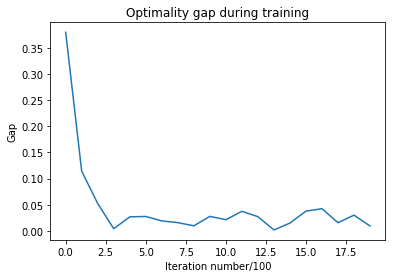

In [19]:
f = plt.figure
plt.plot(np.array(gap))
plt.title('Optimality gap during training')
plt.ylabel('Gap')
plt.xlabel('Iteration number/100')